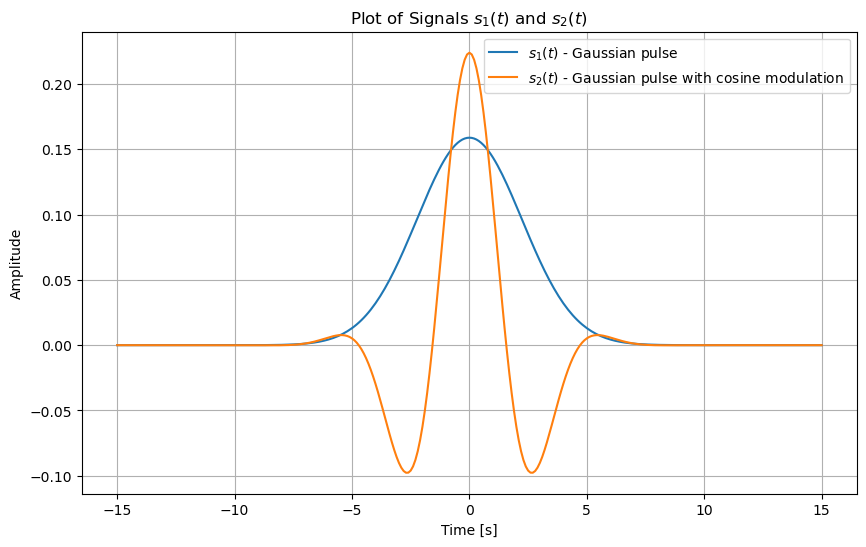

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define the time range
Ts = 0.1  # Sampling interval
t = np.arange(-15, 15 + Ts, Ts)

# Define the signals
s1 = np.exp(-0.1 * t**2)  # Gaussian pulse
s2 = np.exp(-0.1 * t**2) * np.cos(t)  # Gaussian pulse modulated by cosine

# Normalize signals to unit energy
E1 = np.sum(s1**2)
E2 = np.sum(s2**2)
s1 = s1 / np.sqrt(E1)
s2 = s2 / np.sqrt(E2)

# Plot the signals
plt.figure(figsize=(10, 6))
plt.plot(t, s1, label='$s_1(t)$ - Gaussian pulse')
plt.plot(t, s2, label='$s_2(t)$ - Gaussian pulse with cosine modulation')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Plot of Signals $s_1(t)$ and $s_2(t)$')
plt.legend()
plt.grid()
plt.show()


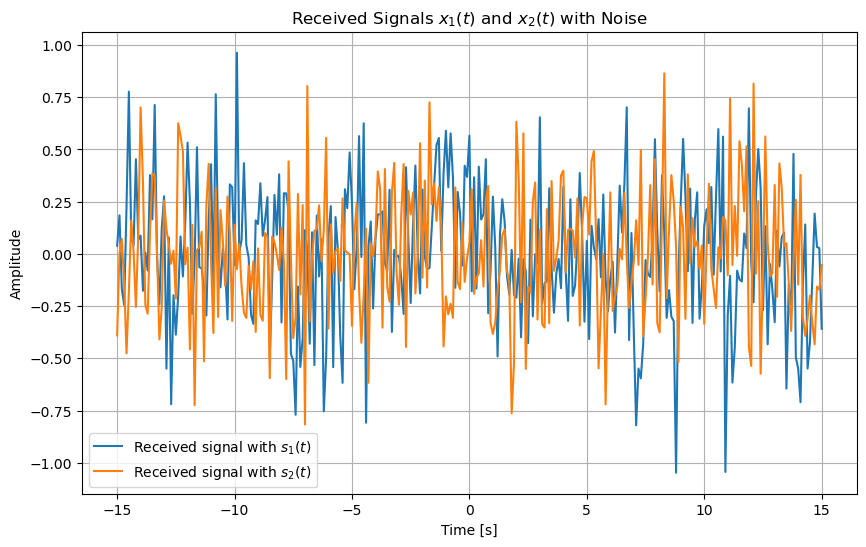

In [2]:
# Generate the received signal x(t)
def generate_signal(s, T, noise_variance):
    """Generate received signal x(t) with time delay T and Gaussian noise."""
    delayed_signal = np.interp(t, t - T, s)  # Time-shifted signal
    noise = np.sqrt(noise_variance) * np.random.randn(len(t))  # Gaussian noise
    x = delayed_signal + noise
    return x

# Example parameters
T_true = 1  # True delay in seconds
noise_variance = 0.1  # Noise variance

# Generate noisy received signals for s1 and s2
x1 = generate_signal(s1, T_true, noise_variance)
x2 = generate_signal(s2, T_true, noise_variance)

# Plot the noisy received signals
plt.figure(figsize=(10, 6))
plt.plot(t, x1, label='Received signal with $s_1(t)$')
plt.plot(t, x2, label='Received signal with $s_2(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Received Signals $x_1(t)$ and $x_2(t)$ with Noise')
plt.legend()
plt.grid()
plt.show()


In [3]:
def ml_estimate(x, s, T_range, step_size=0.01):
    """Perform Maximum Likelihood estimation of T using grid search."""
    best_T = None
    best_error = float('inf')
    
    T_values = np.arange(T_range[0], T_range[1], step_size)
    
    for T in T_values:
        delayed_s = np.interp(t, t - T, s)
        error = np.sum((x - delayed_s)**2)
        
        if error < best_error:
            best_error = error
            best_T = T
    
    return best_T

# Perform ML estimation for both signals
T_est_1 = ml_estimate(x1, s1, [-5, 5])
T_est_2 = ml_estimate(x2, s2, [-5, 5])

print(f"Estimated delay for s1: {T_est_1} seconds")
print(f"Estimated delay for s2: {T_est_2} seconds")


Estimated delay for s1: 1.009999999999872 seconds
Estimated delay for s2: 2.1599999999998474 seconds


In [4]:
def crb(s, noise_variance):
    """Calculate the Cramér-Rao Bound for a signal."""
    ds = np.gradient(s, Ts)  # Derivative of the signal with respect to time
    Fisher_information = np.sum((ds**2) / noise_variance)
    CRB = 1 / Fisher_information
    return CRB

# Calculate CRB for both signals
CRB_s1 = crb(s1, noise_variance)
CRB_s2 = crb(s2, noise_variance)

print(f"CRB for s1: {CRB_s1}")
print(f"CRB for s2: {CRB_s2}")


CRB for s1: 1.0010003333333182
CRB for s2: 0.09191830534945636


In [5]:
def monte_carlo_simulation(s, num_trials=1000 , noise_variance=0.1):
    """Monte Carlo simulation to estimate RMSE of ML estimator."""
    T_true_values = np.random.uniform(-5, 5, num_trials)
    T_est_values = []
    
    for T_true in T_true_values:
        x = generate_signal(s, T_true, noise_variance)
        T_est = ml_estimate(x, s, [-5, 5])
        T_est_values.append(T_est)
    
    T_est_values = np.array(T_est_values)
    rmse = np.sqrt(np.mean((T_true_values - T_est_values)**2))
    return rmse

# Perform Monte Carlo simulation for both signals
rmse_s1 = monte_carlo_simulation(s1)
rmse_s2 = monte_carlo_simulation(s2)

print(f"RMSE for s1: {rmse_s1}")
print(f"RMSE for s2: {rmse_s2}")


RMSE for s1: 1.437329079641017
RMSE for s2: 1.2946878483322843


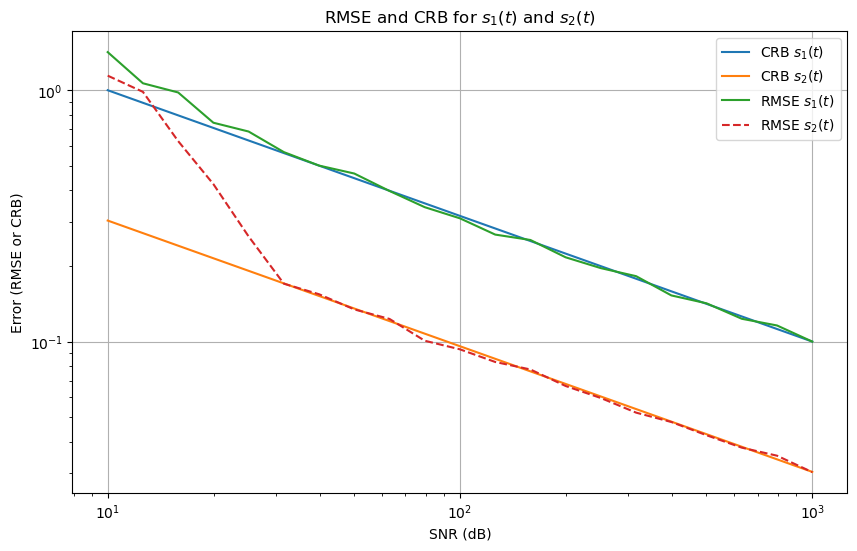

In [6]:
SNR_dB = np.arange(10, 31, 1)  # SNR values in dB
SNR_linear = 10**(SNR_dB / 10)  # Convert SNR from dB to linear scale

# Calculate CRB and RMSE for each SNR value
CRB_s1_values = []
CRB_s2_values = []
rmse_s1_values = []
rmse_s2_values = []

for snr in SNR_linear:
    noise_variance = 1 / snr
    CRB_s1_values.append(crb(s1, noise_variance))
    CRB_s2_values.append(crb(s2, noise_variance))
    rmse_s1_values.append(monte_carlo_simulation(s1, noise_variance=noise_variance))
    rmse_s2_values.append(monte_carlo_simulation(s2, noise_variance=noise_variance))

# Plot CRB and RMSE
plt.figure(figsize=(10, 6))
plt.plot(SNR_linear, np.sqrt(CRB_s1_values), label='CRB $s_1(t)$')
plt.plot(SNR_linear, np.sqrt(CRB_s2_values), label='CRB $s_2(t)$')
plt.plot(SNR_linear, rmse_s1_values, label='RMSE $s_1(t)$', linestyle='solid')
plt.plot(SNR_linear, rmse_s2_values, label='RMSE $s_2(t)$', linestyle='--')
plt.xlabel('SNR (dB)')
plt.ylabel('Error (RMSE or CRB)')
plt.title('RMSE and CRB for $s_1(t)$ and $s_2(t)$')
plt.legend()
plt.grid()
plt.xscale('log')
plt.yscale('log')
plt.show()
